In [23]:
# Developed for TensorFlow, but it can also be used for Pytorch
# https://www.tensorflow.org/tensorboard

# [VI] Doc for using it w/ Pytorch: https://pytorch.org/docs/stable/tensorboard.html

In [24]:
# We will use the same code from tutorial #13 (Feedforward NN with MNIST dataset)
# Installig  TensorBoard: > conda install tensorboard (or 'pip' if you dont use a conda environment) 

In [25]:
# To start Tensorboard
# > tensorboard --logdir=runs   ('runs' is the default folder)
# (it will become available usually at localhost:6006.  Disregard the warning of 'Tensorflow installation not found')

torch.Size([100, 1, 28, 28]) torch.Size([100])
epoch: 1 / 2, step: 100 / 600, loss: 0.3119
epoch: 1 / 2, step: 200 / 600, loss: 0.0850
epoch: 1 / 2, step: 300 / 600, loss: 0.1443
epoch: 1 / 2, step: 400 / 600, loss: 0.1352
epoch: 1 / 2, step: 500 / 600, loss: 0.1619
epoch: 1 / 2, step: 600 / 600, loss: 0.1858
epoch: 2 / 2, step: 100 / 600, loss: 0.1155
epoch: 2 / 2, step: 200 / 600, loss: 0.2472
epoch: 2 / 2, step: 300 / 600, loss: 0.1335
epoch: 2 / 2, step: 400 / 600, loss: 0.0546
epoch: 2 / 2, step: 500 / 600, loss: 0.1912
epoch: 2 / 2, step: 600 / 600, loss: 0.1335
accuracy: 96.49%


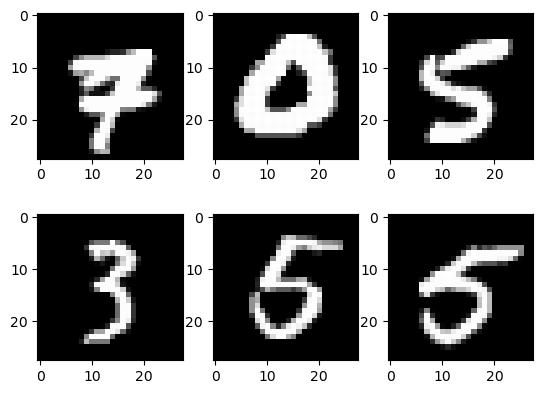

In [26]:
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist")


# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
input_size = 784 # 28*28 (We will flatten image to be a 1-D array)
hidden_size = 100 # You can try out different sizes
num_classes = 10 # digits from 0 to 9
epochs = 2 # You can set this to a higher value (this is just for quicker demo)
batch_size = 100
learning_rate = 0.01

# Import MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=T.ToTensor(),
    download=True # should be downloaded if not available already
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=T.ToTensor() 
    # No neede to download it anymore
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) # Shuffling doesn't matter for the evaluation

# Let's see one batch
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)
# FROM ABOVE: torch.Size([100, 1, 28, 28]) -> 100 batches, 1 channel (only one color), 28, 28

# print 6 examples
for i in range(6):
    plt.subplot(2, 3, i+1) # 2 rows, 3 cols
    plt.imshow(samples[i][0], cmap='gray') # [0] for first channel

# plt.show() -> Instead of plotting, let's add the images to the Tensorboard
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close() # Needed at the end (makes sure all outputs are being flushed)

# Use this to just test if images got saved and displayed correctly in tensorboard before running the time-consuming model training
# sys.exit() # This will stop running the file (wont execute any code below this. Useful for debugging/testing)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        # We usually do not add the activation function here for Multiclass Classification

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)  
        out = self.l2(out)
        # we will use the cross-entropy loss, which will apply the SoftMax for us
        return out


model = NeuralNet(input_size, hidden_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # PS: This will apply the softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
# Adam is an alternative method for Stochastic Gradient Descent
# Adam vs SGD: https://towardsai.net/p/l/why-should-adam-optimizer-not-be-the-default-learning-algorithm

# You will see the graph tab on Tensorboard. Double-click on model to expand it (see its layers)
# Also double-click to expand the layer (weight and bias)
writer.add_graph(model, samples.reshape(-1, 28*28).to(device))
writer.close()
# sys.exit()

# Training Loop
n_total_steps = len(train_loader)
# Add these for tensorboard
running_loss = 0.0
running_correct = 0

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        # reshape our image first -> From [100, 1, 28, 28] to [100, 784]
        # 'to()' will push it to either the CPU or GPU
        images = images.reshape(-1, 28*28).to(device) # '-1' means that tensor will automatically find that for us
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) # predictions ('outputs') vs actual Y ('labels')

        # backward pass
        optimizer.zero_grad() # empty the gradients
        loss.backward()
        optimizer.step() # update setp (udpate the parameters for us)

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1} / {epochs}, step: {i+1} / {n_total_steps}, loss: {loss.item():.4f}')
            writer.add_scalar('Training Loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('Accuracy', running_correct / 100, epoch * n_total_steps + i)
            # reset them to 0 again
            running_loss = 0.0
            running_correct = 0
            # PS: You can make a change to the hyper-parameters (e.g. learning rate) and run again 'change folder to, say runs/mnist3'


# Test (evaluation)

# Added those to use in Tensorboard
labels_tb = []
preds_tb = []

# we don't want to compute the gradients for the steps
with torch.no_grad():
    n_correct_pred = 0
    n_samples = 0

    for images, labels in test_loader:
        # reshape them as well
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images) # Our model is already trained here

        # returns value, index (only interested in the latter, which is the class label)
        _, predictions = torch.max(outputs, 1) # dimension 1
        n_samples += labels.shape[0] # number of samples in the current batch (here it is 100)
        n_correct_pred += (predictions == labels).sum().item() # Each correct prediciton will add 1

        class_predictions = [F.softmax(output, dim=0) for output in outputs] 
        preds_tb.append(class_predictions)
        labels_tb.append(predictions)

    preds_tb = torch.cat([torch.stack(batch) for batch in preds_tb])
    labels_tb = torch.cat(labels_tb) # concatenate all elements into 1-dim tensor

    acc = 100.0 * (n_correct_pred / n_samples)
    print(f'accuracy: {acc}%')

    classes = range(10)
    for i in classes:
        labels_i = labels_tb == i
        preds_i = preds_tb[:, i]
        writer.add_pr_curve("label " + str(i), labels_i, preds_i, global_step=0)
        writer.close()